<a href="https://colab.research.google.com/github/jungeun202/Transformer/blob/main/Transformer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformer model with smaller dataset

In [20]:
import os
import copy
import math
import time

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#- Embedding

If we have,
 \begin{pmatrix}
  \text{I} & \text{love} & \text{banana} \\
  \text{I} & \text{love} & \text{apple} \\
  \text{I} & \text{hate} & \text{banana}
 \end{pmatrix}




We can set vocab:

0. I
1. love
2. banana
3. apple
4. hate

Then input matrix(one-hot vector) will be:

\begin{pmatrix}
  [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0] \\
  [1,0,0,0,0], [0,0,1,0,0], [0,0,0,1,0] \\
  [1,0,0,0,0], [0,0,0,0,1], [0,0,1,0,0]
 \end{pmatrix}


Then input matrix pass Embedding layer with weight $W$ and this weight matrix's shape will be [(5)vocab_size, (d)embedding dimension].

In [21]:
class Embeddings(nn.Module):
  def __init__(self, vocab_num, d_model):
    super(Embeddings,self).__init__()
    self.emb = nn.Embedding(vocab_num,d_model)
    self.d_model = d_model
  def forward(self, x):

    return self.emb(x) * math.sqrt(self.d_model)

#- Encoding

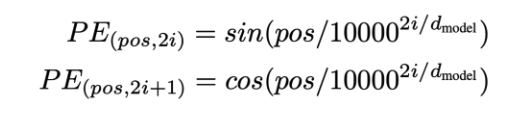


In [22]:
from torch import Tensor

In [23]:
class PositionalEncoding(nn.Module):

    def __init__(self, emb_dim, seq_len):
        super().__init__()

        self.encoding = torch.zeros(seq_len, emb_dim)
        self.encoding.requires_grad = False

        pos = torch.arange(0,seq_len).float().unsqueeze(dim=1)
        _2i = torch.arange(0,emb_dim,step=2).float()

        # self.encoding = (sequence_length, hidden_size)
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i/emb_dim)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i/emb_dim)))

    def forward(self, tensor):
        batch_size, sequence_length = tensor.size()

        # (sequence_length, hidden_size)
        return self.encoding[:sequence_length, :]

#- Self Attention

In [24]:
def self_attention(query, key, value, mask=None):
  key_transpose = torch.transpose(key,-2,-1)
  matmul_result = torch.matmul(query,key_transpose)
  d_k = query.size()[-1]
  attention_score = matmul_result/math.sqrt(d_k)

  if mask is not None:
    attention_score = attention_score.masked_fill(mask == 0, -1e20)

  softmax_attention_score = F.softmax(attention_score,dim=-1)
  result = torch.matmul(softmax_attention_score,value)

  return result, softmax_attention_score



class MultiHeadAttention(nn.Module):
  def __init__(self, head_num , d_model, dropout = 0.1):
    super(MultiHeadAttention,self).__init__()
    assert d_model % head_num == 0

    self.head_num = head_num
    self.d_model = d_model
    self.d_k = self.d_v = d_model // head_num

    self.w_q = nn.Linear(d_model,d_model) # or self.w_q = nn.Linear(d_model, head_num * d_head)
    self.w_k = nn.Linear(d_model,d_model)
    self.w_v = nn.Linear(d_model,d_model)
    self.w_o = nn.Linear(d_model,d_model)

    self.self_attention = self_attention
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask = None):
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)

    batche_num = query.size(0)

    query = self.w_q(query).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
    key = self.w_k(key).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
    value = self.w_v(value).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)

    attention_result, attention_score = self.self_attention(query, key, value, mask)


    attention_result = attention_result.transpose(1,2).contiguous().view(batche_num, -1, self.head_num * self.d_k)


    return self.w_o(attention_result)

#- FeedForward Network

In [25]:
class FeedForward(nn.Module):
  def __init__(self,d_model, dropout = 0.1):
    super(FeedForward,self).__init__()
    self.w_1 = nn.Linear(d_model, d_model*4)
    self.w_2 = nn.Linear(d_model*4, d_model)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

#- Encoder Layer

In [26]:
class Encoder(nn.Module):
  def __init__(self, d_model, head_num, dropout):
    super(Encoder,self).__init__()
    self.multi_head_attention = MultiHeadAttention(d_model= d_model, head_num = head_num)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.feed_forward = FeedForward(d_model)
    self.layer_norm2 = nn.LayerNorm(d_model)

  def forward(self, input, mask):
    out = self.layer_norm1(input + self.multi_head_attention(input, input, input, mask))
    out = self.layer_norm2(out + self.feed_forward(out))

    return out


class Decoder(nn.Module):
  def __init__(self, d_model,head_num, dropout):
    super(Decoder,self).__init__()
    self.masked_multi_head_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
    self.layer_norm1 = nn.LayerNorm(d_model)

    self.encoder_decoder_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
    self.layer_norm2 = nn.LayerNorm(d_model)

    self.feed_forward= FeedForward(d_model)
    self.layer_norm3 = nn.LayerNorm(d_model)


  def forward(self, target, encoder_output, target_mask, encoder_mask):
    # target, x, target_mask, input_mask
    x = self.layer_norm1(target, lambda x: self.masked_multi_head_attention(x, x, x, target_mask))
    x = self.layer_norm2(x, lambda x: self.encoder_decoder_attention(x, encoder_output, encoder_output, encoder_mask))
    x = self.layer_norm3(x, self.feed_forward)

    return x

#- Model

In [27]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TransformerLM(nn.Module):
  def __init__(self, vocab_size, dim,  depth, max_seq_len, head_num, dropout= 0.1):
    super(TransformerLM,self).__init__()

    self.token_emb= nn.Embedding(vocab_size, dim)
    self.position_emb = PositionalEncoding(dim,max_seq_len)
    self.encoders = clones(Encoder(d_model=dim, head_num=head_num, dropout=dropout), depth)
    self.norm = nn.LayerNorm(dim)
    self.lm_head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Linear(dim, vocab_size)
            )
  def subsequent_mask(self, size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

  def forward(self, input_ids, input_mask = None):
    if input_mask is None:
       input_mask = self.subsequent_mask(max_seq_len).to(device)

    x = self.token_emb(input_ids)
    x = x + self.position_emb(input_ids).type_as(x)

    for encoder in self.encoders:
      x = encoder(x, input_mask)
    x = self.norm(x)

    return self.lm_head(x)

#- Dataset

In [28]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)


class Corpus(object):
    def __init__(self):
        self.dictionary = Dictionary()

    def get_data(self, path, batch_size=20):
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize the file content
        ids = torch.LongTensor(tokens)
        token = 0
        with open(path, 'r') as f:
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1
        num_batches = ids.size(0) // batch_size
        ids = ids[:num_batches*batch_size]
        return ids.view(batch_size, -1)

#- Hyper-Parameters Setting

In [29]:
import matplotlib.pyplot as plt

In [30]:
# Hyper-parameters

dim = 128
depth = 1
num_epochs = 5
batch_size = 20
max_seq_len = 15
learning_rate = 0.002
head_num = 8
times = []

sequence_lengths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


#- Training & Evaluation

89
65
Epoch [1/5], Step[0/89], Loss: 7.6171, Perplexity: 2032.62
Epoch [2/5], Step[0/89], Loss: 5.2684, Perplexity: 194.11
Epoch [3/5], Step[0/89], Loss: 4.5805, Perplexity: 97.56
Epoch [4/5], Step[0/89], Loss: 3.9207, Perplexity: 50.43
Epoch [5/5], Step[0/89], Loss: 3.2103, Perplexity: 24.79
Elapsed time: 9.19 seconds
44
32
Epoch [1/5], Step[0/44], Loss: 7.6518, Perplexity: 2104.47
Epoch [2/5], Step[0/44], Loss: 5.7145, Perplexity: 303.25
Epoch [3/5], Step[0/44], Loss: 5.0832, Perplexity: 161.30
Epoch [4/5], Step[0/44], Loss: 4.3491, Perplexity: 77.41
Epoch [5/5], Step[0/44], Loss: 3.6467, Perplexity: 38.35
Elapsed time: 6.07 seconds
29
21
Epoch [1/5], Step[0/29], Loss: 7.6285, Perplexity: 2056.00
Epoch [2/5], Step[0/29], Loss: 5.9173, Perplexity: 371.42
Epoch [3/5], Step[0/29], Loss: 5.4281, Perplexity: 227.71
Epoch [4/5], Step[0/29], Loss: 4.9115, Perplexity: 135.85
Epoch [5/5], Step[0/29], Loss: 4.5570, Perplexity: 95.30
Elapsed time: 4.90 seconds
22
16
Epoch [1/5], Step[0/22], Los

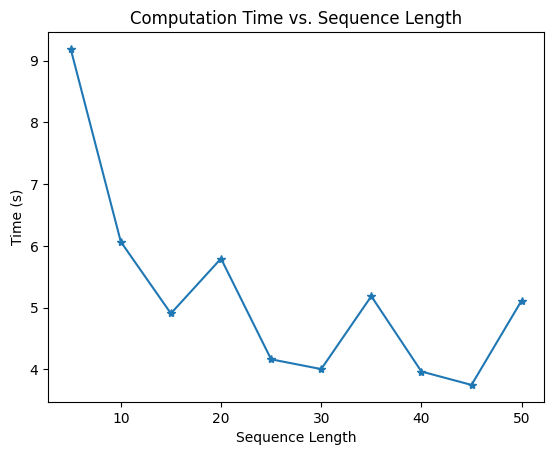

In [31]:
# Train the model
# for max_seq_len in sequence_lengths: # Iterates over different sequence lengths

for max_seq_len in sequence_lengths:
  corpus = Corpus()
  ids = corpus.get_data('/content/drive/MyDrive/train.txt', batch_size)
  vocab_size = len(corpus.dictionary)
  num_batches = ids.size(1) // max_seq_len


  test_corpus = Corpus()
  test_ids = test_corpus.get_data('/content/drive/MyDrive/test.txt', batch_size)
  test_vocab_size =  len(test_corpus.dictionary)
  test_num_batches = test_ids.size(1) // max_seq_len


  vocab_size = len(corpus.dictionary)


  print(num_batches)
  print(test_num_batches)
  model = TransformerLM(vocab_size, dim, depth, max_seq_len, head_num, dropout= 0.1).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  start_time = time.time()
  for epoch in range(num_epochs):

      for i in range(0, ids.size(1) - max_seq_len, max_seq_len):
          # Get mini-batch inputs and targets
          inputs = ids[:, i:i+max_seq_len].to(device)
          targets = ids[:, (i+1):(i+1)+max_seq_len].to(device)

          # Forward pass
          # Starting each batch, we detach the hidden state from how it was previously produced.
          # If we didn't, the model would try backpropagating all the way to start of the dataset.

          outputs = model(inputs)
          output_flat = outputs.view(-1, vocab_size)

          loss = criterion(output_flat, targets.reshape(-1))

          # Backward and optimize
          model.zero_grad()
          loss.backward()
          clip_grad_norm_(model.parameters(), 0.5)
          optimizer.step()

          step = (i+1) // max_seq_len
          if step % 500 == 0:
              print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                    .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))


  elapsed_time = time.time() - start_time
  times.append(elapsed_time)
  print('Elapsed time: {:.2f} seconds'.format(elapsed_time))

plt.plot(sequence_lengths, times, marker='*')
plt.xlabel('Sequence Length')
plt.ylabel('Time (s)')
plt.title('Computation Time vs. Sequence Length')
plt.show()